# Identifying Genomic Mutations for Autism Spectrum Disorder via Deep Learning

In [21]:
%matplotlib inline
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Load the genotype data and check basic informations

We used an autism data set from the Simons Simplex Collection (SSC). The SSC data includes 2,600 simplex families, each of which has one child affected with ASD (a proband), unaffected parents, and at least one unaffected sibling. The data consists of 3,931 individuals whose exome sequences are available, and 2,249 samples of them are labeled as diseased group (Autism).

In [18]:
varfile = "SSC_WES_allVariantAnnotations_04-2015.txt"
df = pd.read_csv(varfile, sep="\t")

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (1,62,75,76,77,78,81) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [306]:
'''The above step takes long time because the data is large. Using this step we can save the dataframe into pickle and load it fast.'''
#df.to_pickle("SSCAnnotations") # save pandas DataFrame to local
df = pd.read_pickle('SSCAnnotations') # don't need to run the above step if run this.

In [307]:
# Variants dataframe annotations
print(df.shape)
df.head(10)

(1504646, 88)


,#varID,Chr,Start,End,Ref,Alt,Func.refGene,Gene.refGene,ExonicFunc.refGene,AAChange.refGene.affectedTranscript(s),...,SiPhy_29way_logOdds,CADDindel,CADDindel_phred,VCF.CHROM,VCF.POS,VCF.ID,VCF.REF,VCF.ALT,VCF.QUAL,VCF.FILTER
0,10_100003856_100003856_C_T,10,100003856,100003856,C,T,exonic,R3HCC1L,nonsynonymous SNV,"NM_001256621,NM_001256620,NM_014472,NM_138469,...",...,19.221,NaN,NaN,10,100003856,.,C,T,1742.33,PASS
1,10_100003874_100003874_C_T,10,100003874,100003874,C,T,exonic,R3HCC1L,nonsynonymous SNV,"NM_001256621,NM_001256620,NM_014472,NM_138469,...",...,14.825,NaN,NaN,10,100003874,rs200017417,C,T,1972.33,PASS
2,10_100003915_100003915_A_G,10,100003915,100003915,A,G,exonic,R3HCC1L,stoploss,"NM_001256621,NM_001256620,NM_014472,NM_138469,...",...,14.541,NaN,NaN,10,100003915,.,A,G,2136.93,PASS
3,10_100003926_100003926_A_G,10,100003926,100003926,A,G,UTR3,R3HCC1L,NaN,NaN,...,NaN,NaN,NaN,10,100003926,.,A,G,1322.33,PASS
4,10_100008654_100008654_A_C,10,100008654,100008654,A,C,UTR3,LOXL4,NaN,NaN,...,NaN,NaN,NaN,10,100008654,.,A,C,1785.05,PASS
5,10_100008704_100008704_G_C,10,100008704,100008704,G,C,exonic,LOXL4,nonsynonymous SNV,NM_032211,...,11.683,NaN,NaN,10,100008704,.,G,C,5379.42,PASS
6,10_100008748_100008748_C_G,10,100008748,100008748,C,G,exonic,LOXL4,nonsynonymous SNV,NM_032211,...,15.548,NaN,NaN,10,100008748,rs142993883,C,G,1772.37,PASS
7,10_100008785_100008785_T_C,10,100008785,100008785,T,C,intronic,LOXL4,NaN,NaN,...,NaN,NaN,NaN,10,100008785,rs117126139,T,C,871.15,PASS
8,10_100010813_100010813_C_T,10,100010813,100010813,C,T,intronic,LOXL4,NaN,NaN,...,NaN,NaN,NaN,10,100010813,rs151200395,C,T,732.42,PASS
9,10_100010814_100010814_G_C,10,100010814,100010814,G,C,intronic,LOXL4,NaN,NaN,...,NaN,NaN,NaN,10,100010814,.,G,C,485.16,PASS


Text(0.5, 0, 'Chromosome')

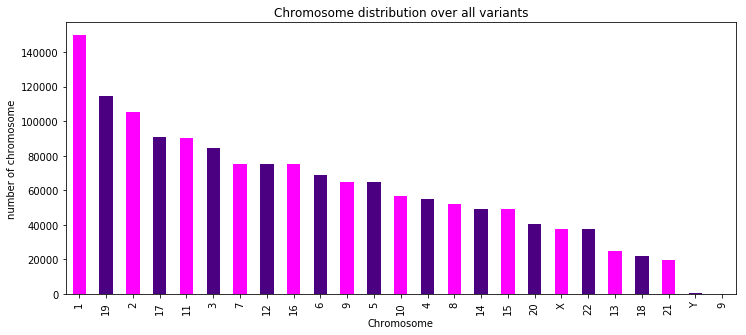

In [389]:
# Chromosome distribution in the annotation file
plt.figure(figsize=(12,5))
chromosome = df[['Chr']]
chromosome['Chr'].value_counts().plot(kind='bar', color=['magenta', 'indigo'])
plt.title('Chromosome distribution over all variants')
plt.ylabel('number of chromosome')
plt.xlabel('Chromosome')

# Data Preprocessing

## Extract Common Variants 
We filter all the 1.5 million variants and extract occuracy frequency greater than 1% as common variants

In [6]:
files= os.listdir("siblings/")
sdic = {}
siblings_population = 0
for file in files:
    s = "siblings/" + file
    siblings_population += 1
    print(siblings_population, end='\r')
    sdf = pd.read_csv(s, sep='\t')
    varID = sdf['#varID'].to_numpy()
    for i in varID:
        if i in sdic:
            sdic[i] = sdic[i] + 1
        else:
            sdic[i] = 1
print('%s: %d' % ('the total number of siblings is',siblings_population))

the total number of siblings is: 1682


In [12]:
with open("common_variants_in_siblings.txt", "w") as f:
    for key in sdic.keys():
        if sdic[key] > siblings_population * 0.01:
            f.write("%s,%d\n"%(key,sdic[key]))

In [9]:
files= os.listdir("probands/")
pdic = {}
probands_population = 0
for file in files:
    s = "probands/" + file
    probands_population += 1
    print(probands_population, end='\r')
    pdf = pd.read_csv(s, sep='\t')
    varID = pdf['#varID'].to_numpy()
    for i in varID:
        if i in pdic:
            pdic[i] = pdic[i] + 1
        else:
            pdic[i] = 1
print('%s: %d' % ('the total number of probands is',probands_population))

the total number of probands is: 2249


In [14]:
with open("common_variants_in_probands.txt", "w") as f:
    for key in pdic.keys():
        if pdic[key] > probands_population * 0.01:
            f.write("%s,%d\n"%(key,pdic[key]))

In [17]:
all_common_variants = open('all_common_variants.txt','w')
scnt = 0
pcnt = 0
for i in sdic:
    if sdic[i] > siblings_population * 0.01:
        scnt += 1
        all_common_variants.writelines(i+'\n')
for j in pdic:
    if pdic[j] > probands_population * 0.01:
        pcnt += 1
        all_common_variants.writelines(j+'\n')

print(scnt)
print(pcnt)

145444
147824


In [ ]:
## read saved variants from files. The function is the same with the above one. So only need to run any of each.
all_common_variants = open('all_common_variants.txt','w')
scnt = 0
pcnt = 0
a = open('variants_in_probands.txt')
b = open('variants_in_siblings.txt')
for al in a:
    #print(int(al.strip().split(',')[1]))
    if int(al.strip().split(',')[1]) > 2249*0.3:
        pcnt += 1
        all_common_variants.writelines(al.strip().split(',')[0]+'\n')
for bl in b:
    if int(bl.strip().split(',')[1]) > 1682*0.3:
        scnt += 1
        all_common_variants.writelines(bl.strip().split(',')[0]+'\n')
        
print('%d,%d,%d' % (pcnt, scnt, pcnt+scnt))

In [3]:
variants_before_selecting_df = pd.read_csv('all_common_variants.txt',sep='\t')
variants_before_selecting_df

,10_100017453_100017453_T_G
0,10_100020880_100020880_C_T
1,10_100021983_100021983_G_A
2,10_100189568_100189568_C_A
3,10_100190920_100190920_G_A
4,10_101090428_101090428_T_G
5,10_101165873_101165873_T_-
6,10_101473218_101473218_A_G
7,10_101542578_101542578_C_T
8,10_101544447_101544447_A_T
9,10_101590619_101590619_C_T


In [4]:
variants_before_selecting_df = variants_before_selecting_df.drop_duplicates()

In [5]:
variants_before_selecting_df.shape

(153347, 1)

In [6]:
variants_before_selecting_df.columns = ['#varID']

#### The number of common variants in siblings is 145,444 and the number of common variants in probands is 147,824

#### The total number of common variants in both siblings and probands is 153,347 (after removing duplicates)

## Filtering variants using genotype quality and read depth


In [7]:
# VCF_DP, VCF_CQ, VCF_GT are in the SSC_WES_allVariantAnnotations.txt files (only keep the following columns)
varinfo = df[['#varID','Chr','Func.refGene','Gene.refGene','ExonicFunc.refGene','CADDindel','CADDindel_phred',
              'VCF.CHROM','VCF.QUAL']]
varinfo.head(10)

,#varID,Chr,Func.refGene,Gene.refGene,ExonicFunc.refGene,CADDindel,CADDindel_phred,VCF.CHROM,VCF.QUAL
0,10_100003856_100003856_C_T,10,exonic,R3HCC1L,nonsynonymous SNV,NaN,NaN,10,1742.33
1,10_100003874_100003874_C_T,10,exonic,R3HCC1L,nonsynonymous SNV,NaN,NaN,10,1972.33
2,10_100003915_100003915_A_G,10,exonic,R3HCC1L,stoploss,NaN,NaN,10,2136.93
3,10_100003926_100003926_A_G,10,UTR3,R3HCC1L,NaN,NaN,NaN,10,1322.33
4,10_100008654_100008654_A_C,10,UTR3,LOXL4,NaN,NaN,NaN,10,1785.05
5,10_100008704_100008704_G_C,10,exonic,LOXL4,nonsynonymous SNV,NaN,NaN,10,5379.42
6,10_100008748_100008748_C_G,10,exonic,LOXL4,nonsynonymous SNV,NaN,NaN,10,1772.37
7,10_100008785_100008785_T_C,10,intronic,LOXL4,NaN,NaN,NaN,10,871.15
8,10_100010813_100010813_C_T,10,intronic,LOXL4,NaN,NaN,NaN,10,732.42
9,10_100010814_100010814_G_C,10,intronic,LOXL4,NaN,NaN,NaN,10,485.16


### VCF_GT re-encoding
For the VCF_GT, if both are reference allele (i.e., 0/0), the value is represented by 0, if only one is reference allele and another one is alternate allele (i.e., 0/1, 1/0, 2/0, 0/2 …), the value is represented as 1. Otherwise, if both are alternate allele (i.e., 1/1, 2/2, 2/1 …), the value is represented as 2.

In [9]:
import re
import math
func = lambda x:(str(x)!='' and str(x) != '.' and bool(re.search('/',str(x))) == False)
func2 = lambda x:(x.isna(np.nan) == False and print(x))
def vcfgt(x):
    output = 1
    flag = False
    x = str(x).split('/')
    if int(x[0]) > 0 and int(x[1]) > 0:
        flag = True 
    if flag:
        output = 2
    return output

In [8]:
probands_list = []
siblings_list = []
father_list = []
mother_list = []

### filtering variants based on VCF_CQ and VCF_DP
The data have the genotype information along with allele depth, read depth, and genotype quality. So I extracted variants that have the genotype quality greater than 90 and read depth greater than 10.

In [10]:
def inputs(file_name):
    #print(file_name)
    p1_df = pd.read_csv(file_name, sep="\t")
    p1_df = p1_df.loc[:, ['#varID', 'VCF.DP', 'VCF.GQ', 'VCF.GT']]
    p1_df.rename(columns={'#varID':'#varID','VCF.DP':'VCF_DP','VCF.GQ':'VCF_GQ','VCF.GT':'VCF_GT'}, inplace=True)
    p1_df = p1_df.loc[(p1_df['VCF_DP'].apply(func)) & (p1_df['VCF_GQ'].apply(func)) & (pd.isnull(p1_df['VCF_GT']) == False)]
    p1_df['VCF_GT'] = p1_df['VCF_GT'].apply(vcfgt)
    p1_df['VCF_DP'] = p1_df.VCF_DP.astype(float)
    p1_df['VCF_GQ'] = p1_df.VCF_GQ.astype(float)
    filter_p1_df = p1_df.loc[(p1_df['VCF_DP'] > 10) & (p1_df['VCF_GQ'] > 90)]
    nfilter_p1_df = filter_p1_df.drop(['VCF_DP','VCF_GQ'],axis=1)
    # nfilter_p1_df = nfilter_p1_df.head(5)
    # nCADD_var_ID = CADD_var_ID.head(5)
    inner_var = variants_before_selecting_df.merge(nfilter_p1_df, how='inner')
    outer_var = variants_before_selecting_df.merge(inner_var, how='outer')
    outer_var = outer_var.drop(['#varID'],axis=1).replace(np.nan,0)
    return outer_var['VCF_GT'].values.tolist() 

In [74]:
files= os.listdir("siblings/")
file_cnt = 0
for file in files:
    s = "siblings/" + file
    returned = inputs(s)
    siblings_list.append(returned)
    file_cnt += 1
    print(file_cnt, end='\r')


In [46]:
fo = open("siblings_data.txt", "w")
for i in siblings_list:
    fo.writelines("%d," % item for item in i)
    fo.writelines('\n')

In [11]:
files= os.listdir("probands/")
file_cnt = 0
for file in files:
    s = "probands/" + file
    returned = inputs(s)
    file_cnt += 1
    print(file_cnt, end='\r')
    probands_list.append(returned)

In [51]:
fo = open("probands_data.txt", "w")
for i in probands_list:
    fo.writelines("%d," % item for item in i)
    fo.writelines('\n')

#### Save the filtered common variants to local file, so we can just load the variables without runing the above steps.

In [75]:
X_siblings = pd.DataFrame(siblings_list)

In [3]:
X_siblings = pd.read_pickle('siblings_data')

In [13]:
X_probands = pd.DataFrame(probands_list)

In [39]:
X_siblings.to_pickle("siblings_data") 
X_probands.iloc[0:1000].to_pickle('probands_data1') # X_probands is too large to save directly. So we saved it into to pickles.
X_probands[1000:].to_pickle('probands_data12')
#X_probands.to_pickle('probands_data') 

In [4]:
# a = pd.read_pickle('probands_data1')
# b = pd.read_pickle('probands_data12')
# X_probands = pd.concat( [a,b], axis=0)
# del a
# del b

In [7]:
header = []
for i in variants_before_selecting_df.values.tolist():
    header.append(i[0])
header.append('label')

### Combine the selected common variants in both siblings and probands to generate the whole data set: whole_data

In [12]:
X_siblings.drop(X_siblings.columns[X_siblings.shape[1]-1],axis=1,inplace=True)
X_probands.drop(X_probands.columns[X_probands.shape[1]-1],axis=1,inplace=True)

In [13]:
X_siblings.iloc[:,-1:X_siblings.shape[1]] = 0
X_probands.iloc[:,-1:X_probands.shape[1]] = 1

In [14]:
whole_data = pd.concat( [X_siblings,X_probands], axis=0)

In [8]:
#whole_data.to_csv('whole_data.csv')
whole_data1 = pd.read_pickle('whole_data1')
whole_data2 = pd.read_pickle('whole_data2')
whole_data3 = pd.read_pickle('whole_data3')
whole_data4 = pd.read_pickle('whole_data4')
whole_data = pd.concat( [whole_data1,whole_data2,whole_data3,whole_data4], axis=0)

# whole_data[0:1000].to_pickle('whole_data1')
# whole_data[1000:2000].to_pickle('whole_data2')
# whole_data[2000:3000].to_pickle('whole_data3')
# whole_data[3000:].to_pickle('whole_data4')

In [ ]:
plt.figure(figsize=(100,20))
plt.imshow(x_train, cmap = 'gray')

### Randomly split the whole data into training and test data. 80% for training and 20% for testing.

In [9]:
whole_data = whole_data.reset_index(drop=True)
#whole_data = whole_data.drop(columns = ['Unnamed: 0'])

In [10]:
from sklearn.utils import shuffle
whole_data = shuffle(whole_data)

In [11]:
import random

train_index = random.sample(range(whole_data.shape[0]), int(whole_data.shape[0]*0.80))

In [12]:
train = whole_data.iloc[train_index]
test = whole_data.drop(train_index)

In [13]:
cols_to_check = train.columns
count = 0
flag = True
#whole_data['is_na'] = whole_data[cols_to_check].isnull().apply(lambda x: all(x), axis=1) 
for i in train[cols_to_check].isnull().any(1).values:
    if i == True:
        print('%d %s' % (count,'contains NaN in train data!'))
        flag = False
    count += 1
if flag:
    print('no row contains NaN in train data')

cols_to_check = test.columns
tcount = 0
tflag = True
for i in test[cols_to_check].isnull().any(1).values:
    if i == True:
        print('%d %s' % (tcount,'contains NaN in test data!'))
        tflag = False
    tcount += 1
if tflag:
    print('no row contains NaN in test data')

no row contains NaN in train data
no row contains NaN in test data


In [14]:
print(train.shape)
print(test.shape)
print(whole_data.shape)
print(len(train_index))

(3144, 153348)
(787, 153348)
(3931, 153348)
3144


In [197]:
train[0:1000].to_pickle('training_data1')
train[1000:2000].to_pickle('training_data2')
train[2000:].to_pickle('training_data3')
test.to_pickle('test_data')

In [15]:
train.columns = header
test.columns = header

In [16]:
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

## Identifying significant variants

## Using Chi-Square to calculate feature importance

Chi-Square test is applied to evaluate the importance of each variant to distinguish the class, in order to select most significant common variants. 

In [17]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
X = train.iloc[:,0:train.shape[1]-1]  #independent columns
y = train.iloc[:,-1]    #target column 
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
featureScores.nlargest(50,'Score')  #print top-50 important variants

,Specs,Score
32276,X_105153001_105153001_A_G,254.188409
32771,X_49021256_49021256_A_G,254.024403
32662,X_3002687_3002687_A_G,247.468955
32726,X_39933339_39933339_A_G,232.126399
32501,X_151092220_151092220_A_G,207.223602
32853,X_69749853_69749853_T_A,198.171562
32772,X_49021537_49021537_G_C,194.536292
32874,X_71342599_71342599_T_C,183.942352
32852,X_69749852_69749852_A_G,178.138556
32387,X_12939928_12939928_T_C,174.545039


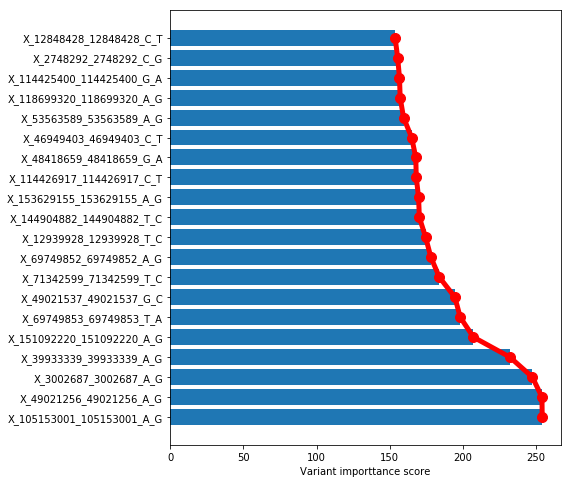

In [574]:
#plot graph of feature importances for better visualization
top_features = featureScores.nlargest(20,'Score')['Specs'].tolist()
top_scores = featureScores.nlargest(20,'Score')['Score'].tolist()
plt.figure(figsize=(7,8))
plt.barh(top_features,top_scores)
plt.plot(top_scores,top_features, linewidth=5, color = 'red', marker="o",  markersize=10)
plt.yticks(featureScores.nlargest(20,'Score')['Specs'].tolist())
plt.xlabel('Variant importtance score')
plt.show()

In [313]:
featureScores.nlargest(100,'Score').to_csv('top_100_features.csv')

In [19]:
important_features = []
[important_features.append(x) for x in featureScores.nlargest(100,'Score')['Specs'].to_list()]
print(important_features)

['X_105153001_105153001_A_G', 'X_49021256_49021256_A_G', 'X_3002687_3002687_A_G', 'X_39933339_39933339_A_G', 'X_151092220_151092220_A_G', 'X_69749853_69749853_T_A', 'X_49021537_49021537_G_C', 'X_71342599_71342599_T_C', 'X_69749852_69749852_A_G', 'X_12939928_12939928_T_C', 'X_144904882_144904882_T_C', 'X_153629155_153629155_A_G', 'X_114426917_114426917_C_T', 'X_48418659_48418659_G_A', 'X_46949403_46949403_C_T', 'X_53563589_53563589_A_G', 'X_118699320_118699320_A_G', 'X_114425400_114425400_G_A', 'X_2748292_2748292_C_G', 'X_12848428_12848428_C_T', 'X_114426171_114426171_C_T', 'X_3228411_3228411_G_A', 'X_153049535_153049535_A_G', 'Y_15027529_15027529_T_G', 'X_35820425_35820425_C_T', 'X_104464277_104464277_A_-', 'X_35821127_35821127_C_T', 'X_130420006_130420006_T_C', 'X_12809661_12809661_G_A', 'X_148628490_148628490_A_T', 'X_2836047_2836047_C_T', 'X_2836084_2836084_C_G', 'X_104464282_104464282_C_-', 'X_49098631_49098631_A_G', 'X_151092126_151092126_C_G', 'X_2856155_2856155_C_T', 'X_2833752_

generating the training data and test data based on the selected contributory common variants

In [27]:
x_train = train[important_features]
x_test = test[important_features]
y_train = train['label']
y_test = test['label']

In [692]:
x_train.to_pickle('x_train')
x_test.to_pickle('x_test')
y_train.to_pickle('y_train')
y_test.to_pickle('y_test')

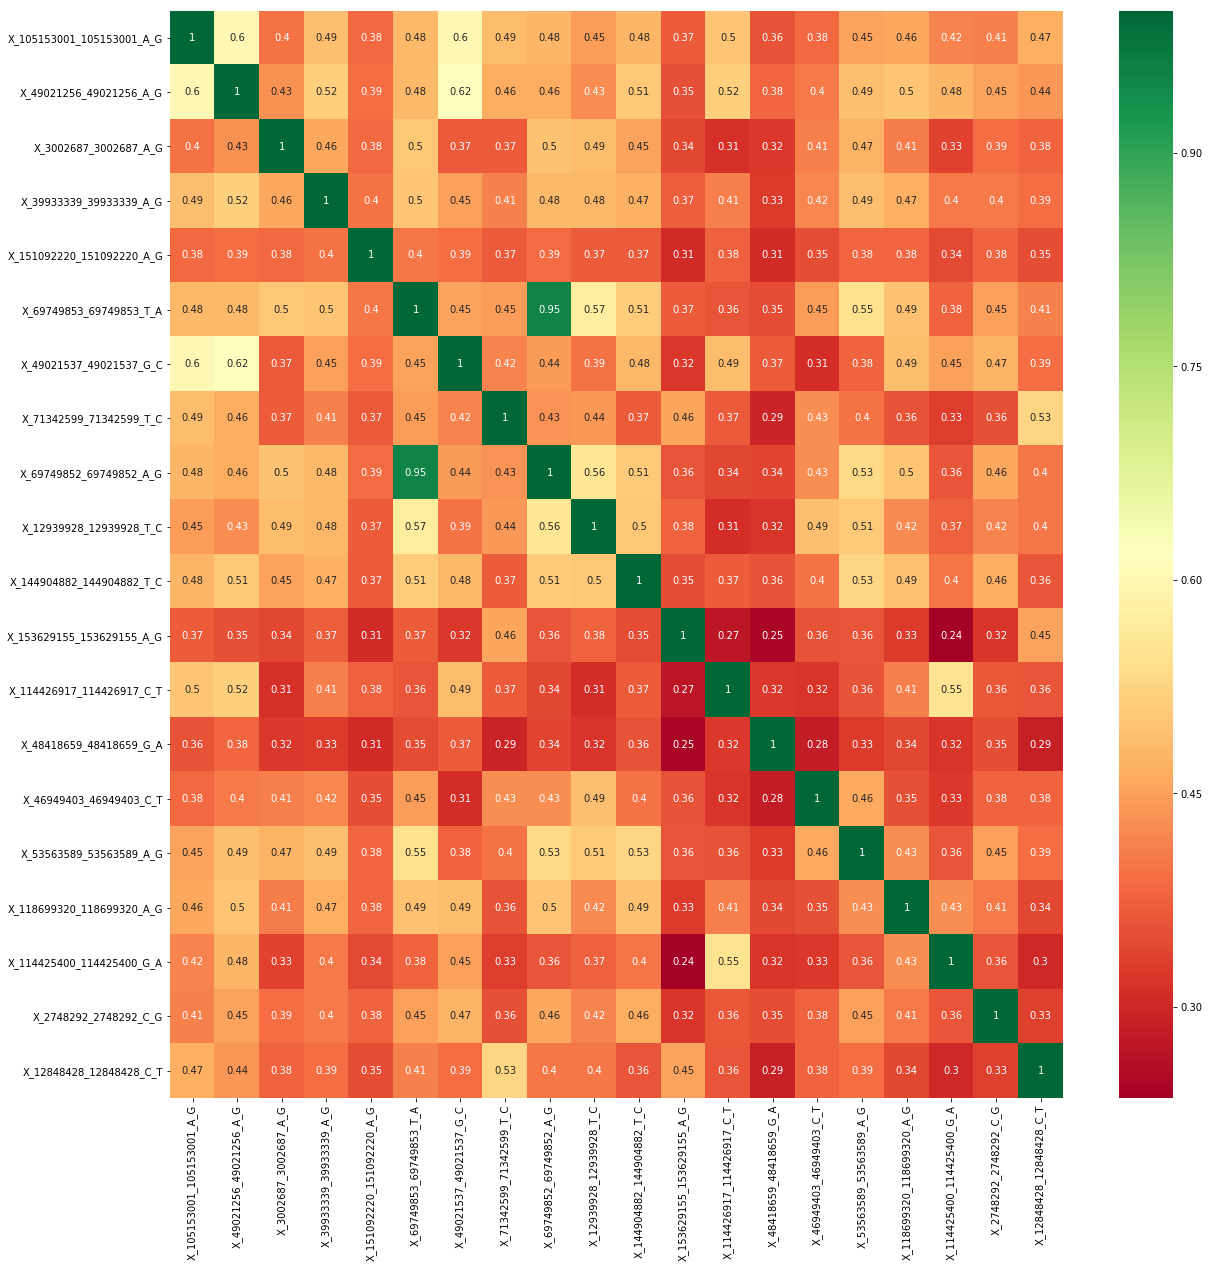

In [494]:
top_important_features = []
[top_important_features.append(x) for x in featureScores.nlargest(20,'Score')['Specs'].to_list()]
#top_important_features.append('label')
train_data = train[top_important_features]

#get correlations of each features in dataset
corrmat = train_data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(train_data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

## Using Logistic Regression

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.7039390088945362


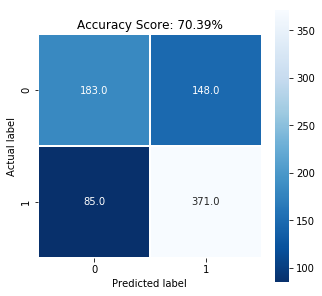

In [87]:
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression()
logisticRegr.fit(x_train, y_train)
lg_predictions = logisticRegr.predict(x_test)
score = logisticRegr.score(x_test, y_test)
print(score)
cm = metrics.confusion_matrix(y_test, lg_predictions)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".1f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format('%1.2f%%' % (score*100))
plt.title(all_sample_title, size = 12);

In [88]:
y_pred_lg = logisticRegr.predict_proba(x_test)[:, 1]
fpr_lg, tpr_lg, thresholds_lg = roc_curve(y_test, y_pred_lg)
auc_lg = metrics.auc(fpr_lg, tpr_lg)
auc_lg

0.7306573647108708

## Using Random Forest

In [515]:
from sklearn.ensemble import RandomForestClassifier
# Supervised transformation based on random forests
rf = RandomForestClassifier(max_depth=10, n_estimators=500)
rf.fit(x_train.to_numpy(), y_train.values.astype(int))
y_pred_rf = rf.predict(x_test)
#x_pred_rf = rf.predict(x_train)
print("Random Forest Accuracy:",metrics.accuracy_score(y_test, y_pred_rf))

Random Forest Accuracy: 0.8081321473951716


Random Forest AUC:  0.896118


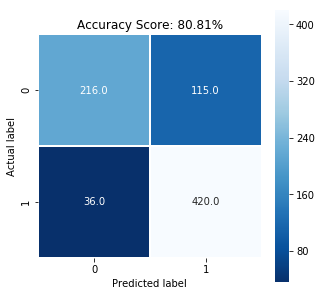

In [516]:
cm = metrics.confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".1f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format('%1.2f%%' % (metrics.accuracy_score(y_test, y_pred_rf)*100))
plt.title(all_sample_title, size = 12);
from sklearn import metrics
y_pred_rf = rf.predict_proba(x_test)[:, 1]
fpr_rf, tpr_rf, thresholds_rf_t = roc_curve(y_test, y_pred_rf)
auc_rf = metrics.auc(fpr_rf, tpr_rf)
print('%s %f' % ('Random Forest AUC: ',auc_rf))


## Using Naive Bayes

naive bayes test accuracy:  0.678526
Naive Bayes AUC:  0.689034


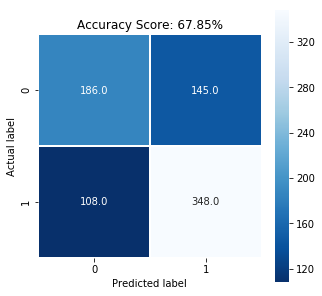

In [517]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()

gnb.fit(x_train.to_numpy(), y_train.values.astype(int))
y_pred_nb = gnb.predict(x_test)

from sklearn.metrics import accuracy_score

print('%s %f' % ('naive bayes test accuracy: ',accuracy_score(y_test, y_pred_dt)))

cm = metrics.confusion_matrix(y_test, y_pred_nb)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".1f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format('%1.2f%%' % (accuracy_score(y_test, y_pred_nb)*100))
plt.title(all_sample_title, size = 12);

y_pred_nb = gnb.predict_proba(x_test)[:, 1]
fpr_nb, tpr_nb, thresholds_nb = roc_curve(y_test, y_pred_nb)
auc_nb = metrics.auc(fpr_nb, tpr_nb)
print('%s %f' % ('Naive Bayes AUC: ',auc_nb))

## Using CNN classifier

In [25]:
from numpy import array
from numpy import argmax
from keras.utils import to_categorical

# one hot encode
y_train_encoded = to_categorical(array([i for i in y_train.to_numpy()]))

Using TensorFlow backend.


In [31]:
keras_x_train = x_train.to_numpy().reshape((x_train.shape[0],x_train.shape[1],1))
keras_x_test = x_test.to_numpy().reshape((x_test.shape[0],x_test.shape[1],1))
input_shape = keras_x_test.shape[1:]

In [126]:
import tensorflow as tf
from tensorflow import keras
from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, Conv1D, Dropout
from keras.layers.convolutional import Convolution1D, MaxPooling1D

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
#model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(rate = 0.5))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(rate = 0.5))
# model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
# model.add(Dropout(rate = 0.5))
# model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
sgd = SGD(lr=0.01, momentum=0.08)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [127]:
history = model.fit(keras_x_train,y_train, batch_size=128, epochs=95)

Epoch 1/95
3144/3144 [==============================] - 3s 857us/step - loss: 0.6609 - acc: 0.6209
Epoch 2/95
3144/3144 [==============================] - 2s 498us/step - loss: 0.6239 - acc: 0.6826
Epoch 3/95
3144/3144 [==============================] - 2s 515us/step - loss: 0.6102 - acc: 0.6982
Epoch 4/95
3144/3144 [==============================] - 2s 515us/step - loss: 0.6022 - acc: 0.7061
Epoch 5/95
3144/3144 [==============================] - 2s 509us/step - loss: 0.6043 - acc: 0.7045
Epoch 6/95
3144/3144 [==============================] - 2s 512us/step - loss: 0.5997 - acc: 0.7048
Epoch 7/95
3144/3144 [==============================] - 2s 511us/step - loss: 0.5942 - acc: 0.7039
Epoch 8/95
3144/3144 [==============================] - 2s 502us/step - loss: 0.5935 - acc: 0.7090
Epoch 9/95
3144/3144 [==============================] - 2s 506us/step - loss: 0.5863 - acc: 0.7109
Epoch 10/95
3144/3144 [==============================] - 2s 505us/step - loss: 0.5867 - acc: 0.7137
Epoch 11/

3144/3144 [==============================] - 2s 502us/step - loss: 0.2904 - acc: 0.8674
Epoch 84/95
3144/3144 [==============================] - 2s 498us/step - loss: 0.2899 - acc: 0.8680
Epoch 85/95
3144/3144 [==============================] - 2s 517us/step - loss: 0.2938 - acc: 0.8655
Epoch 86/95
3144/3144 [==============================] - 2s 518us/step - loss: 0.2974 - acc: 0.8674
Epoch 87/95
3144/3144 [==============================] - 2s 494us/step - loss: 0.2891 - acc: 0.8702
Epoch 88/95
3144/3144 [==============================] - 2s 497us/step - loss: 0.2721 - acc: 0.8779
Epoch 89/95
3144/3144 [==============================] - 2s 500us/step - loss: 0.2860 - acc: 0.8728
Epoch 90/95
3144/3144 [==============================] - 2s 509us/step - loss: 0.2833 - acc: 0.8747
Epoch 91/95
3144/3144 [==============================] - 2s 510us/step - loss: 0.2755 - acc: 0.8728
Epoch 92/95
3144/3144 [==============================] - 2s 506us/step - loss: 0.2724 - acc: 0.8766
Epoch 93/95


In [128]:
y_test_encoded = to_categorical(array([i for i in y_test.to_numpy()]))
model.evaluate(keras_x_test,y_test)

787/787 [==============================] - 0s 571us/step


[0.28712388899608066, 0.8856416770281906]

In [198]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_17 (Conv1D)           (None, 98, 64)            256       
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 96, 128)           24704     
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 48, 128)           0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 48, 128)           0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 46, 64)            24640     
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 23, 64)            0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 23, 64)            0         
__________

Text(0.5, 0, 'epoch')

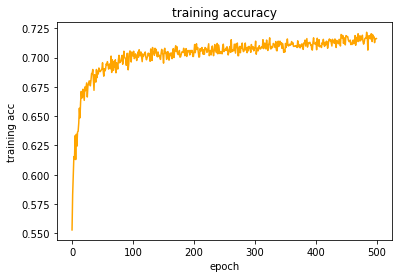

In [342]:
# plot the training accuracy
plt.plot(history.history['acc'],color='orange')
plt.title('training accuracy')
plt.ylabel('training acc')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

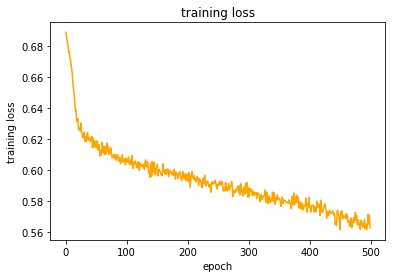

In [343]:
# plot the training loss
plt.plot(history.history['loss'],color='orange')
plt.title('training loss')
plt.ylabel('training loss')
plt.xlabel('epoch')

In [178]:
y_pred_dl = model.predict(keras_x_test).ravel()

In [179]:
from keras import backend as K
dl_pred = []
with tf.Session() as sess:
    tmp = K.round(dl_y_prob).eval()

for i in tmp:
    dl_pred.append(i[0])

dl_acc = np.count_nonzero(dl_pred == y_test)/y_test.shape[0]
print('Prediction Accuracy: %1.2f%%' % (dl_acc*100))

Prediction Accuracy: 88.56%


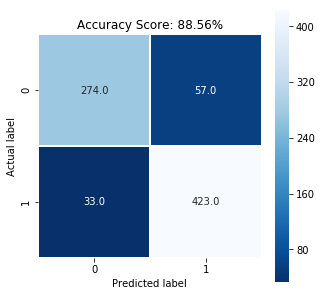

In [180]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, dl_pred)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".1f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format('%1.2f%%' % (dl_acc*100))
plt.title(all_sample_title, size = 12);

In [181]:
fpr_dl, tpr_dl, thresholds_dl = roc_curve(y_test, y_pred_dl)
auc_dl = auc(fpr_dl, tpr_dl)
print('DL Prediction AUC: %1.2f' % (auc_dl))

DL Prediction AUC: 0.95


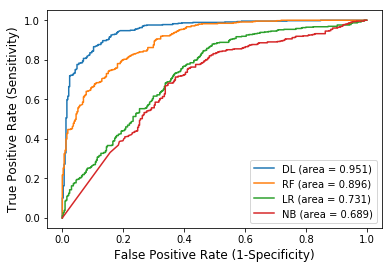

In [536]:
%matplotlib inline
ax = plt.subplot(111)
ax.plot(fpr_dl, tpr_dl, label='DL (area = {:.3f})'.format(auc_dl))
ax.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
ax.plot(fpr_lg, tpr_lg, label='LR (area = {:.3f})'.format(auc_lg))
ax.plot(fpr_nb, tpr_nb, label='NB (area = {:.3f})'.format(auc_nb))
plt.xlabel('False Positive Rate (1-Specificity)', size = 12)
plt.ylabel('True Positive Rate (Sensitivity)', size = 12)
ax.legend()

In [117]:
import tensorflow as tf
from tensorflow import keras

class MyModel(keras.Model):

  def __init__(self, num_classes, activation=None, **kwargs):
    super().__init__(**kwargs)
    self.num_classes = num_classes
    # Define your layers here.
    self.dense_0 = keras.layers.Flatten()
    self.dense_1 = keras.layers.Dense(32, activation='relu')
    self.dense_2 = keras.layers.Dense(64, activation='relu')
    self.dense_3 = keras.layers.Dense(128, activation='relu')
    self.dense_4 = keras.layers.Dense(512, activation='relu')
    self.dense_5 = keras.layers.Dense(128, activation='relu')
    self.dense_6 = keras.layers.Dense(64, activation='relu')
    self.dense_7 = keras.layers.Dense(32, activation='relu')
    self.dense_8 = keras.layers.Dense(1, activation='sigmoid')

  def call(self, inputs):
    # Define your forward pass here,
    # using layers you previously defined (in `__init__`).
    #dense_0 = self.dense_0(inputs)
    dense_1 = self.dense_1(inputs)
    dense_2 = self.dense_2(dense_1)
    dense_3 = self.dense_3(dense_2)
    dense_4 = self.dense_4(dense_3)
    dense_5 = self.dense_5(dense_4)
    dense_6 = self.dense_6(dense_5)
    dense_7 = self.dense_7(dense_6)
    return self.dense_8(dense_7)

  def compute_output_shape(self, input_shape):
    # You need to override this function if you want to use the subclassed model
    # as part of a functional-style model.
    # Otherwise, this method is optional.
    shape = tf.TensorShape(input_shape).as_list()
    shape[-1] = self.num_classes
    return tf.TensorShape(shape)


# Instantiates the subclassed model.
nnmodel = MyModel(num_classes=2)

# The compile step specifies the training configuration.
nnmodel.compile(optimizer=tf.train.GradientDescentOptimizer(0.005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Trains for 5 epochs.
history = nnmodel.fit(x_train.to_numpy(), y_train.to_numpy(), epochs=5, batch_size=128, verbose=1)
score = nnmodel.evaluate(x_test.to_numpy(), y_test.to_numpy())

Epoch 1/5
3144/3144 [==============================] - 0s 128us/sample - loss: 0.6942 - acc: 0.4303
Epoch 2/5
3144/3144 [==============================] - 0s 35us/sample - loss: 0.6910 - acc: 0.4742
Epoch 3/5
3144/3144 [==============================] - 0s 35us/sample - loss: 0.6883 - acc: 0.5617
Epoch 4/5
3144/3144 [==============================] - 0s 37us/sample - loss: 0.6859 - acc: 0.6298
Epoch 5/5
787/787 [==============================] - 0s 233us/sample - loss: 0.6836 - acc: 0.6480


In [119]:
ty_pred_keras = nnmodel.predict(x_test).ravel()
tfpr_keras, ttpr_keras, tthresholds_keras = roc_curve(y_test, ty_pred_keras)
tauc_keras = auc(tfpr_keras, ttpr_keras)
tauc_keras

0.6543998780940266

# Analysis

## 1. visulize the occurancy different is more than 8% in sibling and proband based on the top-50 contributory variants

In [431]:
cvs = pd.read_csv('common_variants_in_siblings.txt')
cvp = pd.read_csv('common_variants_in_probands.txt')
cvs.columns = ['variant','count']
cvp.columns = ['variant','count']
top_feature = featureScores.nlargest(50,'Score')['Specs'].tolist()
cvsibling = []
cvproband = []
for v in top_feature:
    cvsibling.append(cvs[cvs.variant == v]['count'].values[0]/1682*100)
    cvproband.append(cvp[cvp.variant == v]['count'].values[0]/2249*100)

In [294]:
psvariants = list(map(list, zip(*[cvsibling, cvproband])))
psvariants_df = pd.DataFrame(psvariants, columns=['sibling', 'proband'], index=top_feature)
#psvariants_df = pd.DataFrame({'name': top_feature, 'sibling': cvsibling,'proband': cvproband})

sp = psvariants_df.loc[(psvariants_df['sibling'] - psvariants_df['proband'] >= 8)]
ps = psvariants_df.loc[(psvariants_df['proband'] - psvariants_df['sibling'] >= 8)]

psvariants_df = pd.concat([sp,ps],axis=0)
psvariants_df

,sibling,proband
X_3002687_3002687_A_G,80.202140,70.431303
X_151092220_151092220_A_G,61.593341,52.956870
X_114426917_114426917_C_T,82.758621,74.655402
X_48418659_48418659_G_A,55.291320,43.886172
X_46949403_46949403_C_T,69.857313,61.716318
X_114425400_114425400_G_A,82.104637,73.143619
X_3228411_3228411_G_A,76.516052,67.985771
X_153049535_153049535_A_G,52.080856,42.552245
X_35820425_35820425_C_T,68.252081,57.714540
X_35821127_35821127_C_T,69.738407,59.359715


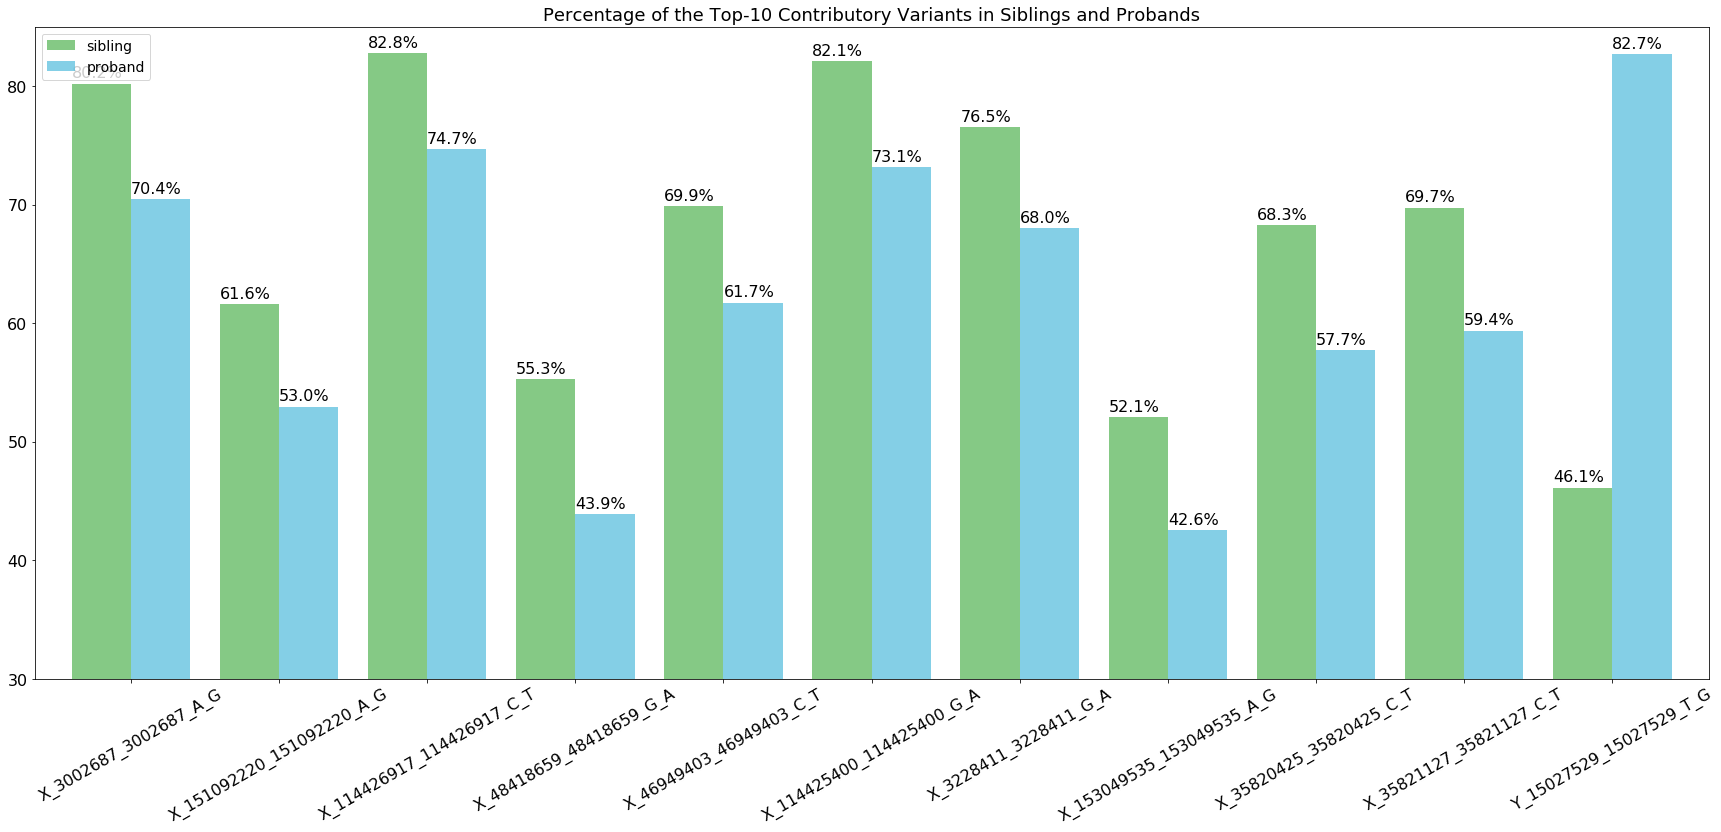

In [303]:
ax = psvariants_df.plot(kind='bar', figsize = (30,12),width = 0.8,color = ['#5cb85c','#5bc0de'],fontsize=16,alpha=0.75, rot=30)
ax.set_title('Percentage of the Top-10 Contributory Variants in Siblings and Probands',fontsize=18)
plt.legend(fontsize=14)
plt.ylim(30, 85)
for i in ax.patches:
    percentage = str(round(i.get_height(),1))+'%'
    ax.text(i.get_x(),i.get_height()+0.5,percentage,fontsize = 16)

## 2. Gene distribution over the top-50 variants

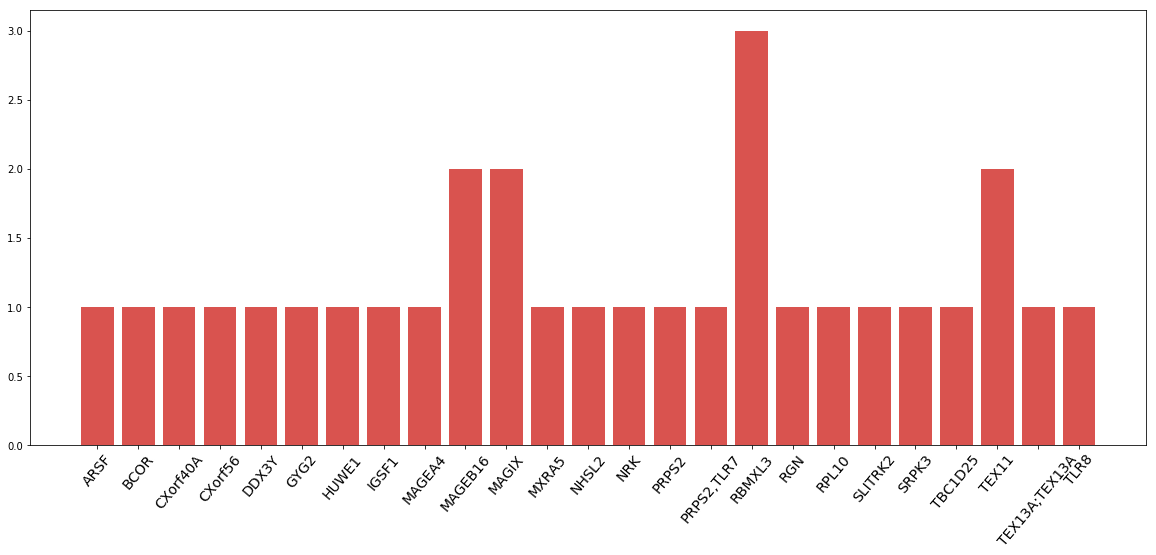

In [308]:
Gene = df.loc[df['#varID'].isin(top_feature)]['Gene.refGene']
genedic = {}
for i in Gene.values:
    if i in genedic:
        genedic[i] = genedic[i] + 1
    else:
        genedic[i] = 1
        
f, ax = plt.subplots(figsize=(20,8))
plt.bar(*zip(*sorted(genedic.items())),color='#d9534f')
plt.xticks(rotation=50,fontsize=14)
plt.show()

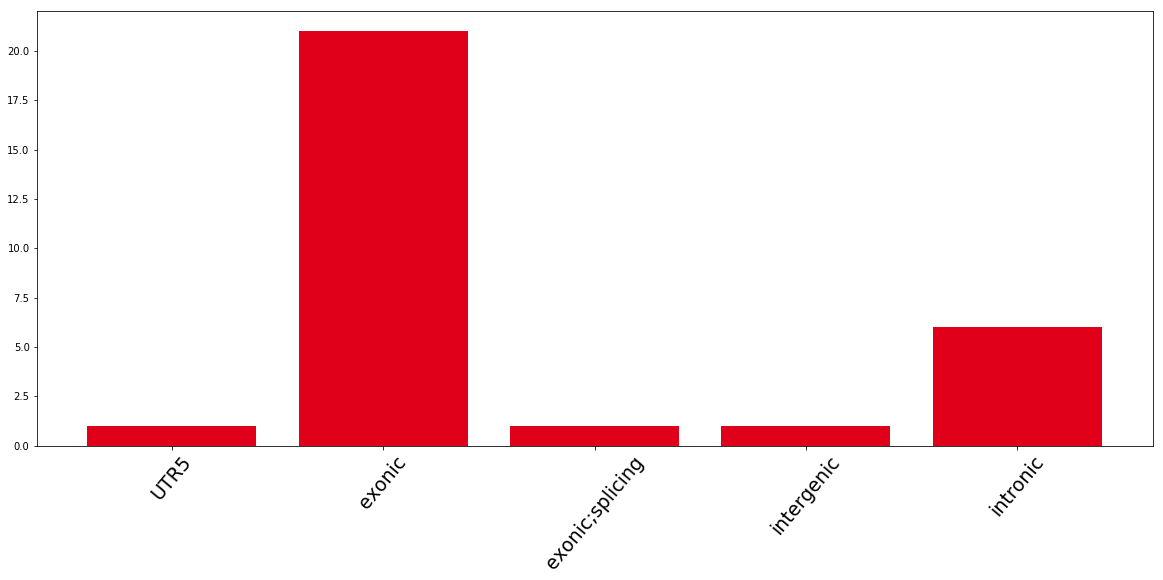

In [309]:
FunGene = df.loc[df['#varID'].isin(top_feature)]['Func.refGene']
fungenedic = {}
for i in FunGene.values:
    if i in fungenedic:
        fungenedic[i] = fungenedic[i] + 1
    else:
        fungenedic[i] = 1
        
f, ax = plt.subplots(figsize=(20,8))
plt.bar(*zip(*sorted(fungenedic.items())),color='#e1001a')
plt.set_cmap('hot')
plt.xticks(rotation=50,fontsize=19)
plt.show()

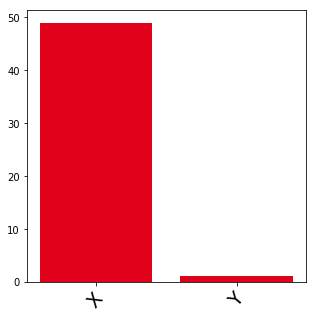

In [452]:
chorm = df.loc[df['#varID'].isin(top_feature)]['VCF.CHROM']
chromdic = {}
for i in chorm.values:
    if i in chromdic:
        chromdic[i] = chromdic[i] + 1
    else:
        chromdic[i] = 1
        
f, ax = plt.subplots(figsize=(5,5))
plt.bar(*zip(*sorted(chromdic.items())),color='#e1001a')
plt.set_cmap('hot')
plt.xticks(rotation=50,fontsize=19)
plt.show()

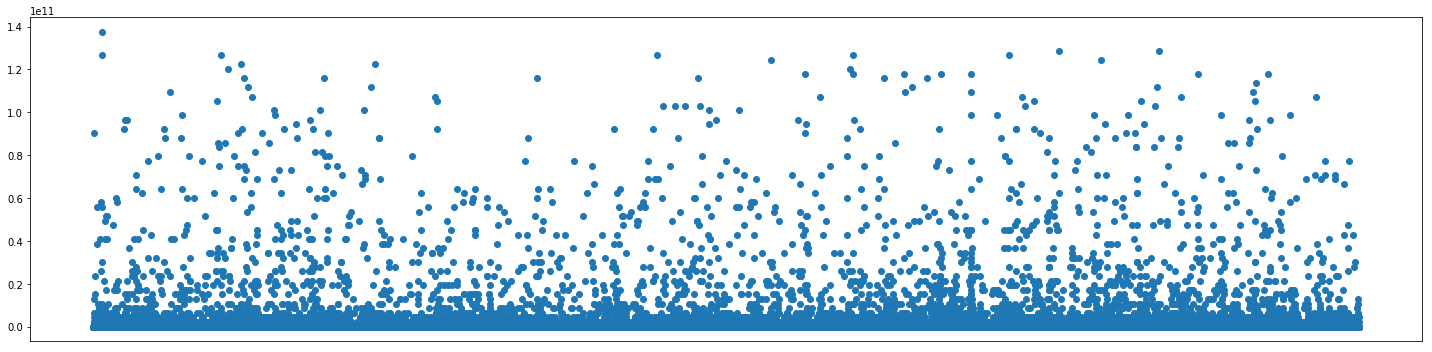

In [310]:
qual = df['VCF.QUAL'].values

range_qual = range(0,len(qual))

f, ax = plt.subplots(figsize=(20,5))
plt.scatter(range_qual,qual)
plt.xticks([],[])
#plt.subplots_adjust(left=0)
plt.tight_layout()

## Pathway analysis

In [410]:
df.columns

Index(['#varID', 'Chr', 'Start', 'End', 'Ref', 'Alt', 'Func.refGene',
       'Gene.refGene', 'ExonicFunc.refGene',
       'AAChange.refGene.affectedTranscript(s)',
       'AAChange.refGene.affectedExon(s)', 'AAChange.refGene.cDNAchange(s)',
       'AAChange.refGene.proteinChange(s)', 'Func.knownGene', 'Gene.knownGene',
       'ExonicFunc.knownGene', 'AAChange.knownGene.affectedTranscript(s)',
       'AAChange.knownGene.affectedExon(s)',
       'AAChange.knownGene.cDNAchange(s)',
       'AAChange.knownGene.proteinChange(s)', 'Func.ensGene', 'Gene.ensGene',
       'ExonicFunc.ensGene', 'AAChange.ensGene.affectedTranscript(s)',
       'AAChange.ensGene.affectedExon(s)', 'AAChange.ensGene.cDNAchange(s)',
       'AAChange.ensGene.proteinChange(s)', 'MSigDBv4_2', 'avsnp142',
       'PopFreqMax', '1000G_ALL', '1000G_AFR', '1000G_AMR', '1000G_EAS',
       '1000G_EUR', '1000G_SAS', 'ExAC_ALL', 'ExAC_AFR', 'ExAC_AMR',
       'ExAC_EAS', 'ExAC_FIN', 'ExAC_NFE', 'ExAC_OTH', 'ExAC_SAS',
       'ESP

In [440]:
VCFID = df.loc[df['#varID'].isin(top_feature[0:20])]['VCF.ID']
pvalue = p_value.loc[p_value['variants'].isin(top_feature[0:20])]['p-value']
pd.DataFrame(np.column_stack([VCFID, top_feature[0:20], pvalue]), 
                               columns=['SNP', 'variants', 'p-value'])

,SNP,variants,p-value
0,rs209372,X_105153001_105153001_A_G,7.93549e-06
1,rs12857270,X_49021256_49021256_A_G,1.47241e-05
2,rs4911809,X_3002687_3002687_A_G,0.000362152
3,rs5910616,X_39933339_39933339_A_G,3.66377e-17
4,rs5978582,X_151092220_151092220_A_G,2.0351e-06
5,rs2109135,X_69749853_69749853_T_A,1.20452e-92
6,rs2748588,X_49021537_49021537_G_C,0.056812
7,rs1047248,X_71342599_71342599_T_C,4.36282e-06
8,rs12012747,X_69749852_69749852_A_G,4.35395e-99
9,rs6641656,X_12939928_12939928_T_C,0.000141859


In [199]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

principalComponents = pca.fit_transform(test[important_features].to_numpy())

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [224]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=1500)
tsne_results = tsne.fit_transform(test[important_features].to_numpy())

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 787 samples in 0.002s...
[t-SNE] Computed neighbors for 787 samples in 0.135s...
[t-SNE] Computed conditional probabilities for sample 787 / 787
[t-SNE] Mean sigma: 2.022902
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.643562
[t-SNE] KL divergence after 1500 iterations: 0.862854


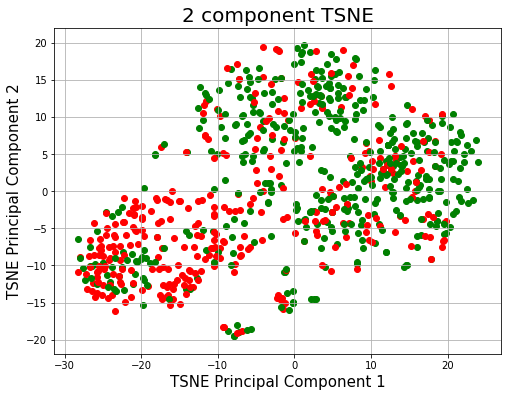

In [482]:
tsneDf = pd.DataFrame(data = tsne_results
             , columns = ['principal component 1', 'principal component 2'])
# create a figure and axis
fig, ax = plt.subplots(figsize=(8,6))

# plot each data-point
for i in range(test[important_features].shape[0]):
    if test['label'].to_numpy()[i] == 0:
        ax.scatter(tsneDf['principal component 1'][i], tsneDf['principal component 2'][i],color='r')
    elif test['label'].to_numpy()[i] == 1:
        ax.scatter(tsneDf['principal component 1'][i], tsneDf['principal component 2'][i],color='g')

# set a title and labels
ax.set_xlabel('TSNE Principal Component 1', fontsize = 15)
ax.set_ylabel('TSNE Principal Component 2', fontsize = 15)
ax.set_title('2 component TSNE', fontsize = 20)
# targets = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
# ax.legend(targets)
ax.grid()

We first reduce the number of dimensions before feeding the data into the t-SNE algorithm. For this we used PCA again. We  first create a new dataset containing the fifty dimensions generated by the PCA reduction algorithm. We can then use this dataset to perform the t-SNE on

Amazingly, the first 50 components roughly hold around 91% of the total variation in the data.

In [259]:
from sklearn.decomposition import PCA

tpca = PCA(n_components=50)

tprincipalComponents = tpca.fit_transform(test[important_features].to_numpy())

tprincipalDf = pd.DataFrame(data = tprincipalComponents)

In [326]:
print('Cumulative explained variation for 50 principal components: {}'.format(np.sum(tpca.explained_variance_ratio_)))

Cumulative explained variation for 50 principal components: 0.9058031049362533


In [260]:
ptsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=1500)
ptsne_results = tsne.fit_transform(tprincipalDf.to_numpy())

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 787 samples in 0.002s...
[t-SNE] Computed neighbors for 787 samples in 0.068s...
[t-SNE] Computed conditional probabilities for sample 787 / 787
[t-SNE] Mean sigma: 1.913780
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.041603
[t-SNE] KL divergence after 1500 iterations: 0.817262


(-34.69518132686835,
 28.861452709787937,
 -18.35862819531189,
 21.246991699165232)

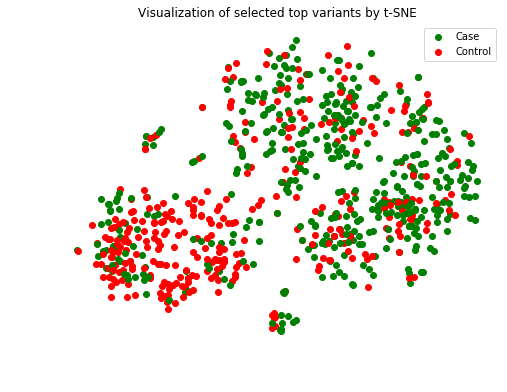

In [481]:
ptsneDf = pd.DataFrame(data = ptsne_results
             , columns = ['principal component 1', 'principal component 2'])
# create a figure and axis
fig, ax = plt.subplots(figsize=(8,6))

# plot each data-point
for i in range(test[important_features].shape[0]):
    if test['label'].to_numpy()[i] == 0:
        ax.scatter(ptsneDf['principal component 1'][i], ptsneDf['principal component 2'][i],color='r')
    elif test['label'].to_numpy()[i] == 1:
        ax.scatter(ptsneDf['principal component 1'][i], ptsneDf['principal component 2'][i],color='g')

# set a title and labels
ax.set_xlabel('tsne-one', fontsize = 15)
ax.set_ylabel('tsne-pca50-two', fontsize = 15)
ax.set_title('Visualization of selected top variants by t-SNE', fontsize = 12)
targets = ['Case', 'Control']
ax.legend(targets)
#ax.grid()
ax.axis('off')

In [467]:
len(x_data.columns)

50

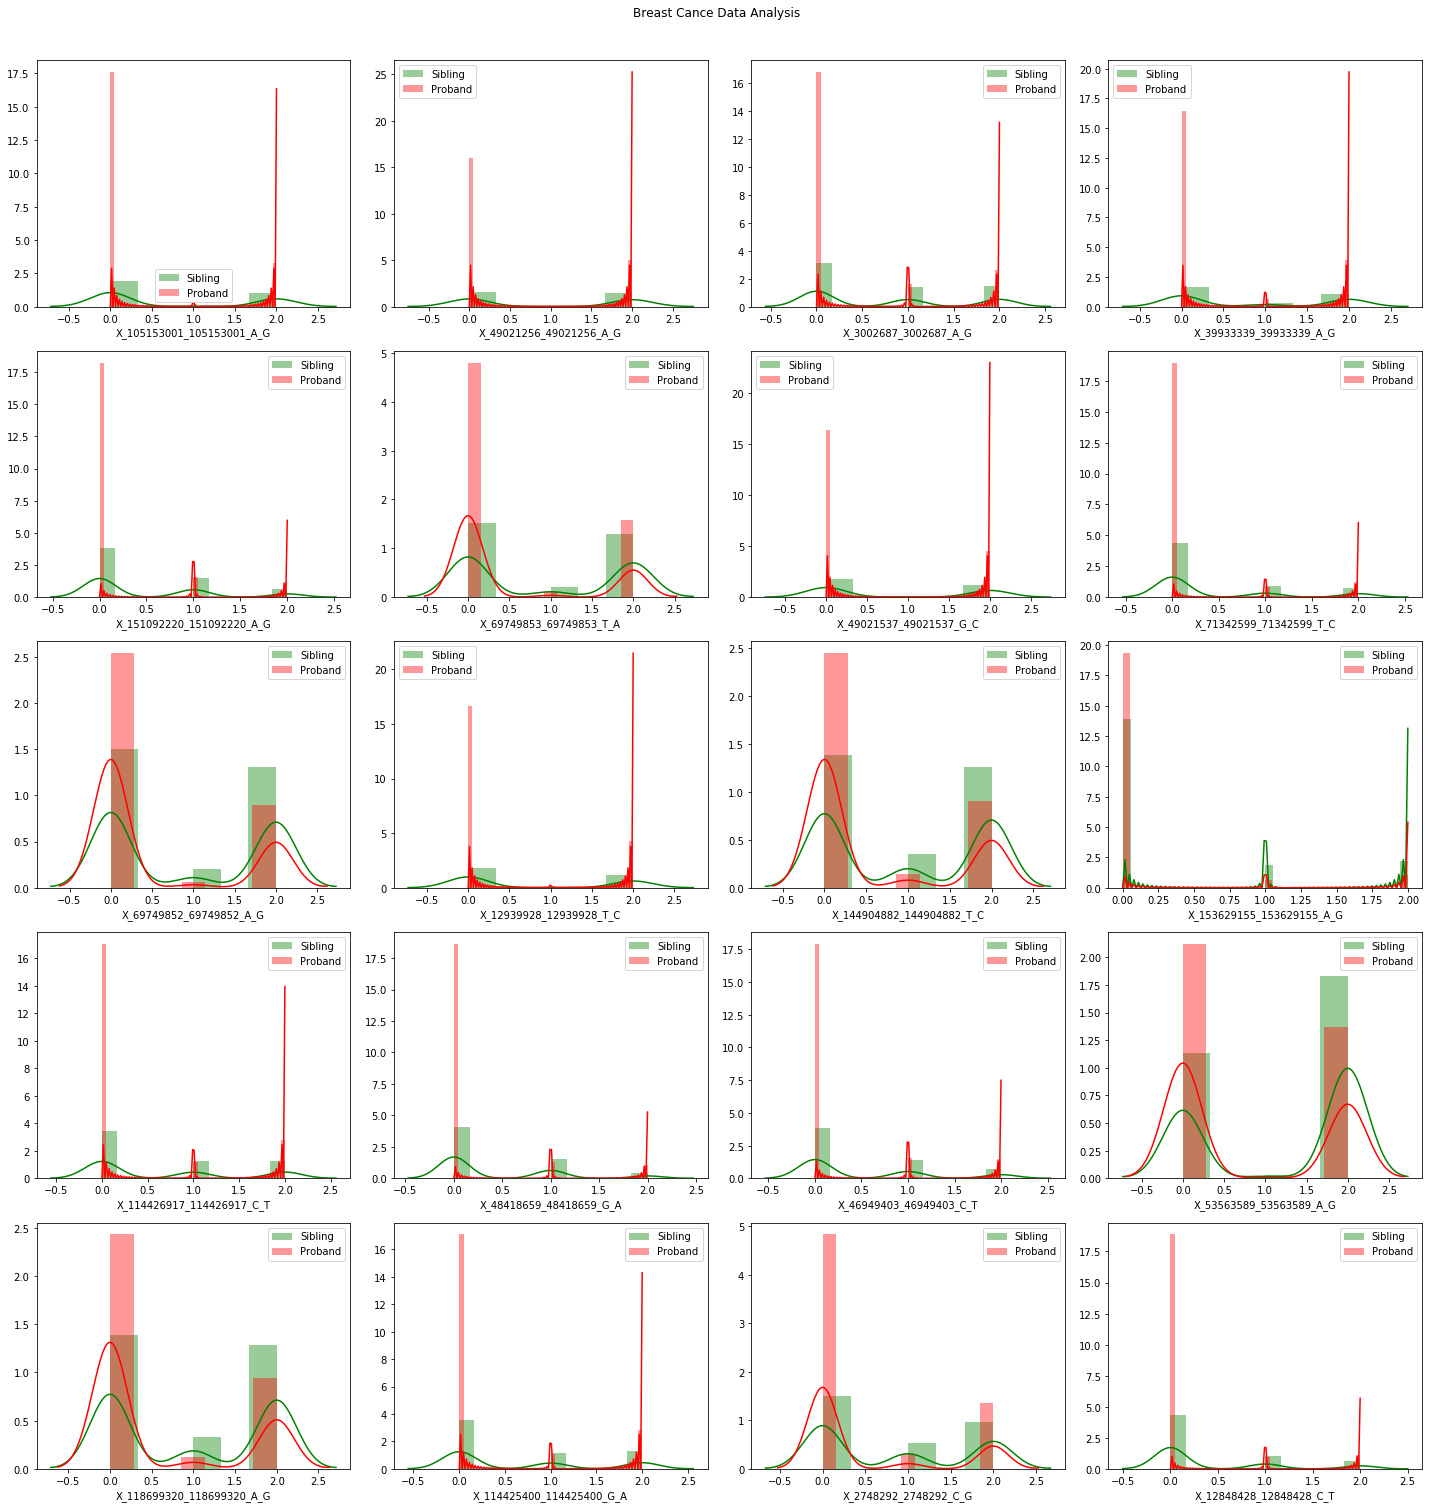

In [471]:
fig = plt.figure(figsize = (20, 25))
j = 0
target = pd.DataFrame()
target['diagnosis'] = y_train
x_data = train[top_feature[0:20]]
for i in x_data.columns:
    plt.subplot(6, 4, j+1)
    j += 1
    sns.distplot(x_data[i][target['diagnosis']==0], color='g', label = 'Sibling')
    sns.distplot(x_data[i][target['diagnosis']==1], color='r', label = 'Proband')
    plt.legend(loc='best')
fig.suptitle('Breast Cance Data Analysis')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

## Compare with random selection

In [754]:
random_y_train = train['label']
random_y_test = test['label']
random_seed = np.random.randint(train.shape[1]-2, size=100)
random_x_train = train.iloc[:,random_seed]
random_x_test = test.iloc[:,random_seed]

In [ ]:
# one hot encode
random_y_train_encoded = to_categorical(array([i for i in random_y_train.to_numpy()]))
random_keras_x_train = random_x_train.to_numpy().reshape((random_x_train.shape[0],random_x_train.shape[1],1))
random_keras_x_test = random_x_test.to_numpy().reshape((random_x_test.shape[0],random_x_test.shape[1],1))
random_input_shape = random_keras_x_test.shape[1:]

randommodel = Sequential()
randommodel.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=random_input_shape))
#model.add(MaxPooling1D(pool_size=2))
randommodel.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
randommodel.add(MaxPooling1D(pool_size=2))
randommodel.add(Dropout(rate = 0.5))
randommodel.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
randommodel.add(MaxPooling1D(pool_size=2))
randommodel.add(Dropout(rate = 0.5))
# model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
# model.add(Dropout(rate = 0.5))
# model.add(MaxPooling1D(pool_size=2))
randommodel.add(Flatten())
randommodel.add(Dense(50, activation='relu'))
randommodel.add(Dense(1, activation='sigmoid'))
#sgd = SGD(lr=0.01, momentum=0.08)
randommodel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

randomhistory = randommodel.fit(random_keras_x_train,random_y_train, batch_size=128, epochs=95)

Epoch 1/95
3144/3144 [==============================] - 6s 2ms/step - loss: 0.6854 - acc: 0.5636
Epoch 2/95
3144/3144 [==============================] - 1s 333us/step - loss: 0.6823 - acc: 0.5751
Epoch 3/95
3144/3144 [==============================] - 1s 321us/step - loss: 0.6811 - acc: 0.5732
Epoch 4/95
3144/3144 [==============================] - 1s 324us/step - loss: 0.6815 - acc: 0.5716
Epoch 5/95
3144/3144 [==============================] - 1s 323us/step - loss: 0.6793 - acc: 0.5744
Epoch 6/95
3144/3144 [==============================] - 1s 330us/step - loss: 0.6801 - acc: 0.5754
Epoch 7/95
3144/3144 [==============================] - 1s 322us/step - loss: 0.6816 - acc: 0.5767
Epoch 8/95
3144/3144 [==============================] - 1s 326us/step - loss: 0.6794 - acc: 0.5751
Epoch 9/95
3144/3144 [==============================] - 1s 324us/step - loss: 0.6804 - acc: 0.5716
Epoch 10/95
3144/3144 [==============================] - 1s 307us/step - loss: 0.6785 - acc: 0.5770
Epoch 11/95

In [752]:
random_y_test_encoded = to_categorical(array([i for i in random_y_test.to_numpy()]))
randommodel.evaluate(random_keras_x_test,random_y_test)

787/787 [==============================] - 2s 2ms/step


[0.6371017155986577, 0.6340533678989095]

Prediction Accuracy: 68.87%


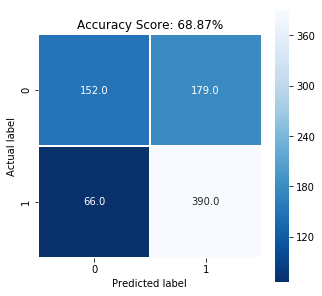

In [719]:
random_dl_y_prob = randommodel.predict(random_keras_x_test).ravel()
from keras import backend as K
random_dl_pred = []
with tf.Session() as sess:
    random_dl_pred = K.round(random_dl_y_prob).eval()
# print(tmp)
# for i in tmp:
#     cadd_dl_pred.append(i)

random_dl_acc = np.count_nonzero(random_dl_pred == random_y_test)/random_y_test.shape[0]
print('Prediction Accuracy: %1.2f%%' % (random_dl_acc*100))

randomcm = confusion_matrix(random_y_test, random_dl_pred)
plt.figure(figsize=(5,5))
sns.heatmap(randomcm, annot=True, fmt=".1f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format('%1.2f%%' % (random_dl_acc*100))
plt.title(all_sample_title, size = 12);

In [753]:
random_dl_pred = randommodel.predict(random_keras_x_test).ravel()
random_fpr_dl, random_tpr_dl, random_thresholds_keras = roc_curve(random_y_test, random_dl_pred)
random_auc_dl = auc(random_fpr_dl, random_tpr_dl)
print('DL Prediction AUC: %1.2f' % (random_auc_dl))

DL Prediction AUC: 0.67


naive bayes test accuracy:  0.453621
Naive Bayes AUC:  0.555779


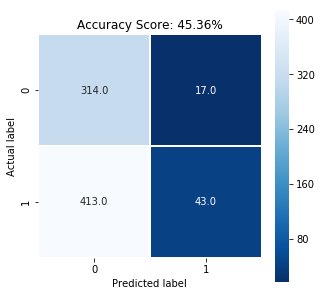

In [640]:
from sklearn.naive_bayes import GaussianNB
randomgnb = GaussianNB()

randomgnb.fit(random_x_train.to_numpy(), random_y_train.values.astype(int))
random_y_pred_nb = randomgnb.predict(random_x_test)


print('%s %f' % ('naive bayes test accuracy: ',accuracy_score(random_y_test, random_y_pred_nb)))

randomcm = metrics.confusion_matrix(random_y_test, random_y_pred_nb)
plt.figure(figsize=(5,5))
sns.heatmap(randomcm, annot=True, fmt=".1f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format('%1.2f%%' % (accuracy_score(random_y_test, random_y_pred_nb)*100))
plt.title(all_sample_title, size = 12);

random_y_pred_nb = randomgnb.predict_proba(random_x_test)[:, 1]
random_fpr_nb, random_tpr_nb, random_thresholds_nb = metrics.roc_curve(random_y_test, random_y_pred_nb)
random_auc_nb = metrics.auc(random_fpr_nb, random_tpr_nb)
print('%s %f' % ('Naive Bayes AUC: ',random_auc_nb))

Random Forest Accuracy: 0.6289707750952986
Random Forest AUC:  0.700612


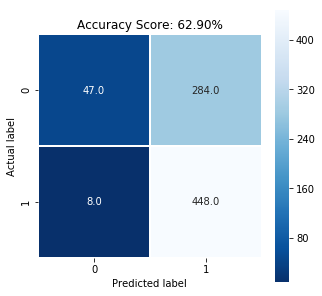

In [749]:
from sklearn.ensemble import RandomForestClassifier
# Supervised transformation based on random forests
randomrf = RandomForestClassifier(max_depth=10, n_estimators=500)
randomrf.fit(random_x_train.to_numpy(), random_y_train.values.astype(int))
random_y_pred_rf = randomrf.predict(random_x_test)
#x_pred_rf = rf.predict(x_train)
print("Random Forest Accuracy:",metrics.accuracy_score(random_y_test, random_y_pred_rf))


randomcm = metrics.confusion_matrix(random_y_test, random_y_pred_rf)
plt.figure(figsize=(5,5))
sns.heatmap(randomcm, annot=True, fmt=".1f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format('%1.2f%%' % (metrics.accuracy_score(random_y_test, random_y_pred_rf)*100))
plt.title(all_sample_title, size = 12);
from sklearn import metrics
random_y_pred_rf = randomrf.predict_proba(random_x_test)[:, 1]
random_fpr_rf, random_tpr_rf, random_thresholds_rf_t = metrics.roc_curve(random_y_test, random_y_pred_rf)
random_auc_rf = metrics.auc(random_fpr_rf, random_tpr_rf)
print('%s %f' % ('Random Forest AUC: ',random_auc_rf))


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.5832274459974587
Logistic Regression AUC:  0.571249


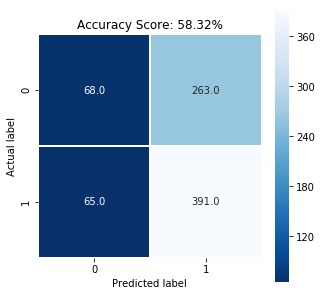

In [690]:
from sklearn.linear_model import LogisticRegression
random_logisticRegr = LogisticRegression()
random_logisticRegr.fit(random_x_train, random_y_train)
random_lg_predictions = random_logisticRegr.predict(random_x_test)
random_score = random_logisticRegr.score(random_x_test, random_y_test)
print(random_score)
randomcm = metrics.confusion_matrix(random_y_test, random_lg_predictions)
plt.figure(figsize=(5,5))
sns.heatmap(randomcm, annot=True, fmt=".1f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format('%1.2f%%' % (random_score*100))
plt.title(all_sample_title, size = 12);

random_y_pred_lg = random_logisticRegr.predict_proba(random_x_test)[:, 1]
random_fpr_lg, random_tpr_lg, random_thresholds_lg = metrics.roc_curve(random_y_test, random_y_pred_lg)
random_auc_lg = metrics.auc(random_fpr_lg, random_tpr_lg)
print('%s %f' % ('Logistic Regression AUC: ',random_auc_lg))

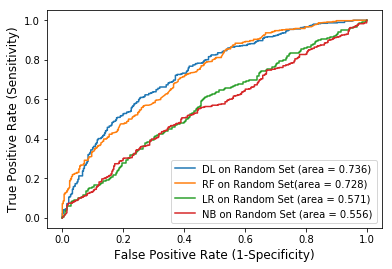

In [744]:
%matplotlib inline
ax = plt.subplot(111)
#ax.plot(cadd_fpr_dl, cadd_tpr_dl, label='CADD (area = {:.3f})'.format(cadd_auc_dl))
ax.plot(random_fpr_dl, random_tpr_dl, label='DL on Random Set (area = {:.3f})'.format(random_auc_dl))
ax.plot(random_fpr_rf, random_tpr_rf, label='RF on Random Set(area = {:.3f})'.format(random_auc_rf))
ax.plot(random_fpr_lg, random_tpr_lg, label='LR on Random Set (area = {:.3f})'.format(random_auc_lg))
ax.plot(random_fpr_nb, random_tpr_nb, label='NB on Random Set (area = {:.3f})'.format(random_auc_nb))
plt.xlabel('False Positive Rate (1-Specificity)', size = 12)
plt.ylabel('True Positive Rate (Sensitivity)', size = 12)
ax.legend()